# Project of Fuzzy

**Goal of the project** <br> Implement the Horizontal representation (collection of $\alpha$-cuts) for continuous fuzzy set, such that it is compatible with softpy (https://github.com/AndreaCampagner/softpy)

**Why?** <br> The horizontal representation for continuous fuzzy sets is useful to have efficient computation of operations and to generalize the implementation of fuzzy numbers

## Importing the necessary Libraries

In [79]:
# SoftPy
from softpy.fuzzy.fuzzyset import *
from softpy.fuzzy.operations import *

# Additional libraries
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

## Class implementation

### AlphaFuzzySet

In the Horizontal representation a fuzzy set F can be represented as a family of sets A($\alpha$) for $\alpha\in[0, 1]$ where $$A(\alpha)= [ x\in X : F(x) \geq \alpha ] $$ such that the degree of membership of $x$ can be reconstructed as $$ F(x) = sup[ \alpha\in [0,1] : x\in A(\alpha) ]$$

Computationally implemented as a collection of collections: a fuzzy set is represented by a collection $\alpha$ where each of its elements is a collection of elements in $x$ having $F(x) \geq \alpha$. This in continuous fuzzy sets is given by intervals.

In [80]:
class TransformFuncIntoAlphaCut(ContinuousFuzzySet):
    def __init__(self, min_val, max_val, func, collection=None):
        super().__init__()
        # min_val and max_val are used to describe the part of the real x-axis I consider, to not consider infinities
        self.min_val = min_val
        self.max_val = max_val
        # epsilon: approximation degree s.t. operators can be implemented, even if not exactly
        self.epsilon = 0.01
        # Membership function
        self.func = func

        if collection is not None:
            if not isinstance(collection, dict):
                raise TypeError("Collection must be a dictionary")
            for key, intervals in collection.items():
                if not all(self.validate_interval(interval) for interval in intervals):
                    raise ValueError(f"Invalid intervals found in collection for alpha {key}: {intervals}")

        self.collection = collection if collection is not None else self.compute_alphaCut()
        self.min = self.compute_min()
        self.max = self.compute_max()
    
    def validate_interval(self, interval):
        return isinstance(interval, tuple) and len(interval) == 2 and interval[0] <= interval[1] and interval[0] >= 0 and interval[1] >= 0

    def compute_alphaCut(self):
        alpha_cuts = {} # Dictionary that will have as key an alpha and as values the intervals of x
        x_values = np.linspace(self.min_val, self.max_val, num=int((self.max_val - self.min_val) / self.epsilon) + 1)
        f_values = self.func(x_values)

        for alpha in np.arange(0, 1.01, self.epsilon):
            intervals = []
            start = None
            for x, y in zip(x_values, f_values):
                if alpha == 0:
                    intervals = [(self.min_val, self.max_val)]
                    alpha_cuts[alpha] = intervals
                    break
                elif alpha > 0:
                    if y >= alpha:
                        if start is None:
                            start = x
                    else:
                        if start is not None:
                            intervals.append((start, x))
                            start = None
            if start is not None:
                intervals.append((start, self.max_val))
            if intervals:
                valid_intervals = [interval for interval in intervals if self.validate_interval(interval)]
                if valid_intervals:
                    alpha_cuts[alpha] = valid_intervals

        return alpha_cuts

    def compute_min(self):
        minVal = float('inf')
        for intervals in self.collection.values():
            for interval in intervals:
                if self.validate_interval(interval):
                    minVal = min(minVal, interval[0])
        return minVal if min_val != float('inf') else self.min_val
    
    def compute_max(self):
        maxVal = float('-inf')
        for intervals in self.collection.values():
            for interval in intervals:
                if self.validate_interval(interval):
                    maxVal = max(maxVal, interval[1])
        return max_val if max_val != float('-inf') else self.max_val

    # Method: __getitem__
    def __getitem__(self, alpha):
        return self.collection.get(alpha, [])

    # Method: __call__
    def __call__(self, element):
        for alpha in sorted(self.collection.keys(), reverse=True):
            if any(interval[0] <= element <= interval[1] for interval in self.collection[alpha] if self.validate_interval(interval)):
                return alpha
        return 0

    # Method: __eq__
    def __eq__(self, other):
        if not isinstance(other, AlphaFuzzySet):
            return False
        return self.collection == other.collection
    
    # Method: hartley
    # Description: returns the hartley entropy of the fuzzy set
    def hartley(self) -> np.number:
        pass

In [81]:
# Example with triangular membership function
def triangular_membership_function(x, a, b, c):
    return np.maximum(0, np.minimum((x - a) / (b - a), (c - x) / (c - b)))
a=1
b=6
c=8
min_val=a-1
max_val=c+1

triangular_func = lambda x: triangular_membership_function(x, a, b, c)

alpha_fuzzy_set_triangular = TransformFuncIntoAlphaCut(min_val, max_val, triangular_func)

print("For the Triangular membership function:")
print(f"Collection of collections: {alpha_fuzzy_set_triangular.compute_alphaCut()}")
print(f"Alpha cut at 0.5: {alpha_fuzzy_set_triangular[0.5]}") # Get method
print(f"Membership degree of element 8: {alpha_fuzzy_set_triangular(8)}") # Call method

For the Triangular membership function:
Collection of collections: {0.0: [(0, 9)], 0.01: [(1.05, 7.98)], 0.02: [(1.1, 7.97)], 0.03: [(1.1500000000000001, 7.94)], 0.04: [(1.21, 7.930000000000001)], 0.05: [(1.25, 7.9)], 0.06: [(1.3, 7.890000000000001)], 0.07: [(1.35, 7.86)], 0.08: [(1.4000000000000001, 7.8500000000000005)], 0.09: [(1.45, 7.82)], 0.1: [(1.5, 7.8100000000000005)], 0.11: [(1.55, 7.78)], 0.12: [(1.6, 7.7700000000000005)], 0.13: [(1.6500000000000001, 7.74)], 0.14: [(1.71, 7.73)], 0.15: [(1.75, 7.7)], 0.16: [(1.8, 7.69)], 0.17: [(1.85, 7.66)], 0.18: [(1.9000000000000001, 7.640000000000001)], 0.19: [(1.95, 7.62)], 0.2: [(2.0, 7.6000000000000005)], 0.21: [(2.06, 7.58)], 0.22: [(2.1, 7.5600000000000005)], 0.23: [(2.16, 7.54)], 0.24: [(2.2, 7.5200000000000005)], 0.25: [(2.25, 7.51)], 0.26: [(2.3000000000000003, 7.48)], 0.27: [(2.35, 7.47)], 0.28: [(2.41, 7.44)], 0.29: [(2.45, 7.43)], 0.3: [(2.5, 7.4)], 0.31: [(2.5500000000000003, 7.390000000000001)], 0.32: [(2.6, 7.36)], 0.33: [(2

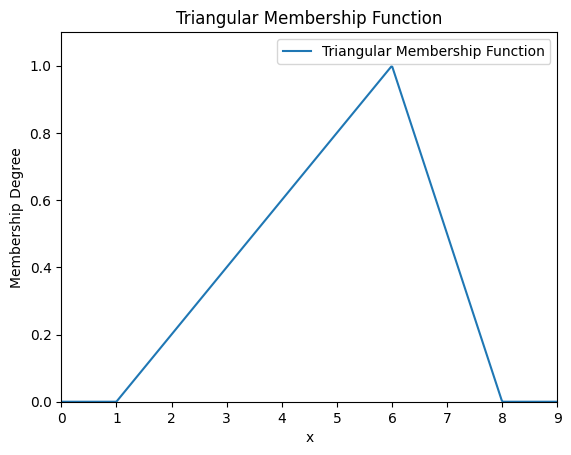

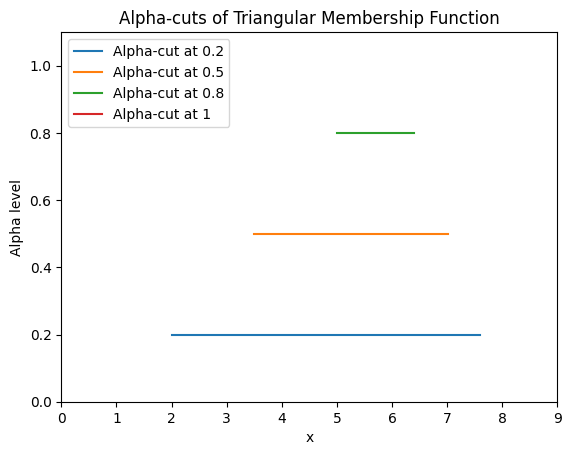

In [82]:
# Plot the triangular membership function
x_values = np.linspace(min_val, max_val, 500)
y_values = triangular_func(x_values)

plt.plot(x_values, y_values, label='Triangular Membership Function')
plt.title('Triangular Membership Function')
plt.xlabel('x')
plt.ylabel('Membership Degree')
plt.xlim(min_val, max_val)
plt.ylim(0, 1.1)
plt.legend()
plt.show()

# Plot the alpha cuts
for alpha in [0.2, 0.5, 0.8, 1]:
    alpha_cut_intervals = alpha_fuzzy_set_triangular[alpha]
    for start, end in alpha_cut_intervals:
        plt.plot([start, end], [alpha, alpha], label=f'Alpha-cut at {alpha}')

plt.title('Alpha-cuts of Triangular Membership Function')
plt.xlabel('x')
plt.ylabel('Alpha level')
plt.xlim(min_val, max_val)
plt.ylim(0, 1.1)
plt.legend()
plt.show()

In [83]:
# Example trapezoidal membership function
def trapezoidal_membership_function(x, a, b, c, d):
    x = np.asarray(x)
    return np.maximum(0, np.minimum(np.minimum((x - a) / (b - a), 1), (d - x) / (d - c)))

a=1
b=6
c=8
d=10
min_val=a-1
max_val=d+1

trapezoidal_func = lambda x: trapezoidal_membership_function(x, a, b, c, d)

alpha_fuzzy_set_trapezoidal = TransformFuncIntoAlphaCut(min_val, max_val, trapezoidal_func)

print("For the Trapezoidal membership function:")
print(f"Collection of collections: {alpha_fuzzy_set_trapezoidal.compute_alphaCut()}")
print(f"Alpha cut at 0.5: {alpha_fuzzy_set_trapezoidal[0.5]}")
print(f"Membership degree of element 3: {alpha_fuzzy_set_trapezoidal(3)}")


For the Trapezoidal membership function:
Collection of collections: {0.0: [(0, 11)], 0.01: [(1.05, 9.98)], 0.02: [(1.1, 9.96)], 0.03: [(1.1500000000000001, 9.950000000000001)], 0.04: [(1.21, 9.93)], 0.05: [(1.25, 9.9)], 0.06: [(1.3, 9.88)], 0.07: [(1.35, 9.870000000000001)], 0.08: [(1.4000000000000001, 9.85)], 0.09: [(1.45, 9.82)], 0.1: [(1.5, 9.8)], 0.11: [(1.55, 9.790000000000001)], 0.12: [(1.6, 9.77)], 0.13: [(1.6500000000000001, 9.74)], 0.14: [(1.71, 9.72)], 0.15: [(1.75, 9.700000000000001)], 0.16: [(1.8, 9.69)], 0.17: [(1.85, 9.66)], 0.18: [(1.9000000000000001, 9.64)], 0.19: [(1.95, 9.620000000000001)], 0.2: [(2.0, 9.61)], 0.21: [(2.06, 9.58)], 0.22: [(2.1, 9.56)], 0.23: [(2.16, 9.540000000000001)], 0.24: [(2.2, 9.53)], 0.25: [(2.25, 9.51)], 0.26: [(2.3000000000000003, 9.48)], 0.27: [(2.35, 9.46)], 0.28: [(2.41, 9.450000000000001)], 0.29: [(2.45, 9.43)], 0.3: [(2.5, 9.4)], 0.31: [(2.5500000000000003, 9.38)], 0.32: [(2.6, 9.370000000000001)], 0.33: [(2.66, 9.35)], 0.34: [(2.7, 9.32

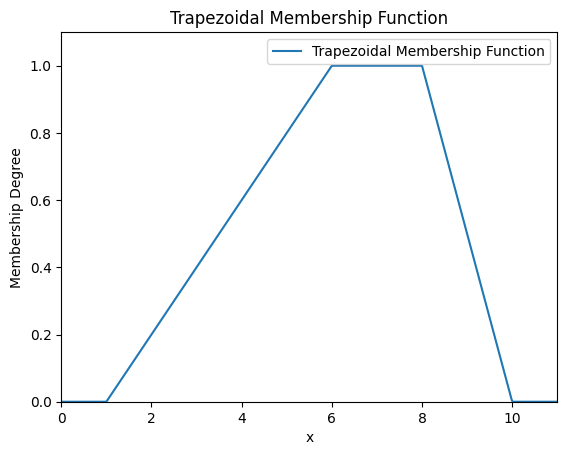

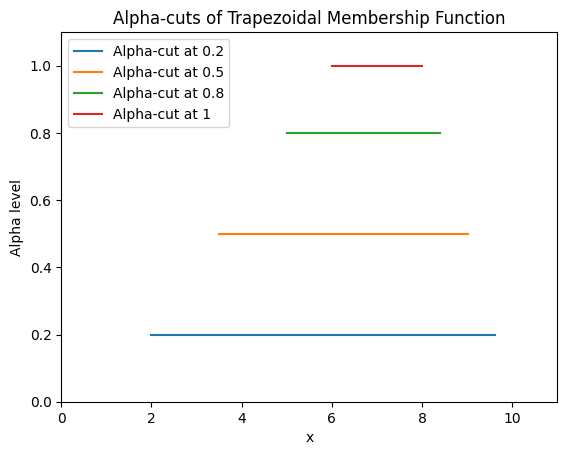

In [84]:
# Plot the trapezoidal membership function
x_values = np.linspace(min_val, max_val, 500)
y_values = trapezoidal_func(x_values)

plt.plot(x_values, y_values, label='Trapezoidal Membership Function')
plt.title('Trapezoidal Membership Function')
plt.xlabel('x')
plt.ylabel('Membership Degree')
plt.xlim(min_val, max_val)
plt.ylim(0, 1.1)
plt.legend()
plt.show()

# Plot the alpha cuts
for alpha in [0.2, 0.5, 0.8, 1]:
    alpha_cut_intervals = alpha_fuzzy_set_trapezoidal[alpha]
    for start, end in alpha_cut_intervals:
        plt.plot([start, end], [alpha, alpha], label=f'Alpha-cut at {alpha}')

plt.title('Alpha-cuts of Trapezoidal Membership Function')
plt.xlabel('x')
plt.ylabel('Alpha level')
plt.xlim(min_val, max_val)
plt.ylim(0, 1.1)
plt.legend()
plt.show()

In [85]:
# Example gaussian membership function
def gaussian_membership_function(x, mean, sigma):
    return np.exp(-0.5 * ((x - mean) / sigma) ** 2)

mean = 5
sigma = 1
min_val = 0
max_val = 10

gaus_func = lambda x: gaussian_membership_function(x, mean, sigma)

alpha_fuzzy_set_gaus = TransformFuncIntoAlphaCut(min_val, max_val, gaus_func)

print("For the Gaussian membership function:")
print(f"Collection of collections: {alpha_fuzzy_set_trapezoidal.compute_alphaCut()}")
print(f"Alpha cut at 0.5: {alpha_fuzzy_set_gaus[0.5]}")
print(f"Membership degree of element 4: {alpha_fuzzy_set_gaus(4)}")

For the Gaussian membership function:
Collection of collections: {0.0: [(0, 11)], 0.01: [(1.05, 9.98)], 0.02: [(1.1, 9.96)], 0.03: [(1.1500000000000001, 9.950000000000001)], 0.04: [(1.21, 9.93)], 0.05: [(1.25, 9.9)], 0.06: [(1.3, 9.88)], 0.07: [(1.35, 9.870000000000001)], 0.08: [(1.4000000000000001, 9.85)], 0.09: [(1.45, 9.82)], 0.1: [(1.5, 9.8)], 0.11: [(1.55, 9.790000000000001)], 0.12: [(1.6, 9.77)], 0.13: [(1.6500000000000001, 9.74)], 0.14: [(1.71, 9.72)], 0.15: [(1.75, 9.700000000000001)], 0.16: [(1.8, 9.69)], 0.17: [(1.85, 9.66)], 0.18: [(1.9000000000000001, 9.64)], 0.19: [(1.95, 9.620000000000001)], 0.2: [(2.0, 9.61)], 0.21: [(2.06, 9.58)], 0.22: [(2.1, 9.56)], 0.23: [(2.16, 9.540000000000001)], 0.24: [(2.2, 9.53)], 0.25: [(2.25, 9.51)], 0.26: [(2.3000000000000003, 9.48)], 0.27: [(2.35, 9.46)], 0.28: [(2.41, 9.450000000000001)], 0.29: [(2.45, 9.43)], 0.3: [(2.5, 9.4)], 0.31: [(2.5500000000000003, 9.38)], 0.32: [(2.6, 9.370000000000001)], 0.33: [(2.66, 9.35)], 0.34: [(2.7, 9.32)],

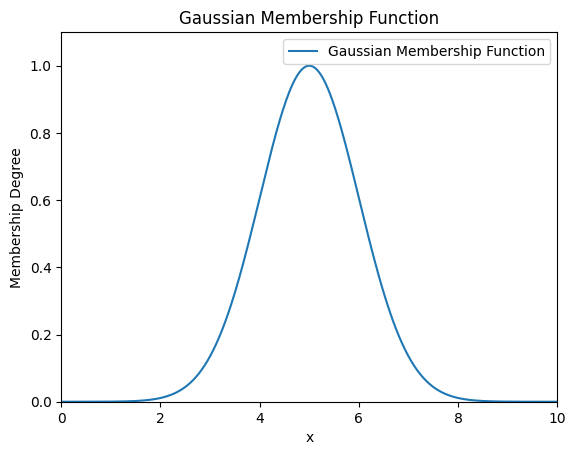

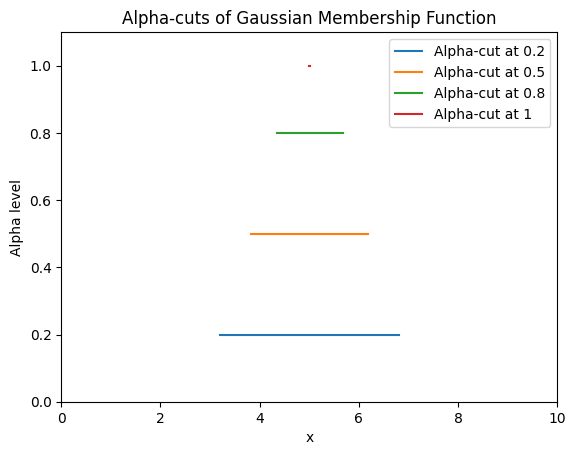

In [86]:
# Plot the gaussian membership function
x_values = np.linspace(min_val, max_val, 500)
y_values = gaus_func(x_values)

plt.plot(x_values, y_values, label='Gaussian Membership Function')
plt.title('Gaussian Membership Function')
plt.xlabel('x')
plt.ylabel('Membership Degree')
plt.xlim(min_val, max_val)
plt.ylim(0, 1.1)
plt.legend()
plt.show()

# Plot the alpha cuts
for alpha in [0.2, 0.5, 0.8, 1]:
    alpha_cut_intervals = alpha_fuzzy_set_gaus[alpha]
    for start, end in alpha_cut_intervals:
        plt.plot([start, end], [alpha, alpha], label=f'Alpha-cut at {alpha}')

plt.title('Alpha-cuts of Gaussian Membership Function')
plt.xlabel('x')
plt.ylabel('Alpha level')
plt.xlim(min_val, max_val)
plt.ylim(0, 1.1)
plt.legend()
plt.show()

In [87]:
class AlphaFuzzySet(ContinuousFuzzySet):
    def __init__(self, collection):
        super().__init__()
        self.collection = self.validate_and_format_collection(collection)
        self.min = self.compute_min()
        self.max = self.compute_max()
        # epsilon: approximation degree s.t. operators can be implemented, even if not exactly
        self.epsilon = 0.01
        self.membership_values = self.infer_membership_values()
    
    def validate_and_format_collection(self, collection):
        if not isinstance(collection, dict):
            raise ValueError("Collection must be a dictionary indexed by alpha values.")
        
        for alpha, intervals in collection.items():
            if not isinstance(alpha, (int, float)) or not (0 <= alpha <= 1):
                raise ValueError(f"Alpha values must be in the range [0, 1]. Invalid alpha: {alpha}")
            if not isinstance(intervals, list) or not all(isinstance(interval, tuple) and len(interval) == 2 for interval in intervals):
                raise ValueError(f"Intervals must be a list of tuples (a, b). Invalid intervals: {intervals}")
        
        return collection

    def infer_membership_values(self):
        membership_values = {}
        for alpha, intervals in self.collection.items():
            for interval in intervals:
                a, b = interval
                if alpha not in membership_values:
                    membership_values[alpha] = []
                membership_values[alpha].append((a, b))
        return membership_values
        
    def compute_min(self):
        min_value = float('inf')
        for intervals in self.collection.values():
            for interval in intervals:
                a = interval[0]
                if a < min_value:
                    min_value = a
        return min_value
    
    def compute_max(self):
        max_value = float('-inf')
        for intervals in self.collection.values():
            for interval in intervals:
                b = interval[1]
                if b > max_value:
                    max_value = b
        return max_value

    # Method: __getitem__
    # Description: Given alpha, returns the alpha-cut of the fuzzy set
    def __getitem__(self, alpha):
        if alpha in self.collection:
            return self.collection[alpha]
        raise KeyError(f"Alpha value {alpha} not found in the collection.")

    # Method: __call__
    # Description: given an element x, returns the degree of membership
    def __call__(self, element):
        for alpha, intervals in sorted(self.collection.items(), reverse=True):
            for interval in intervals:
                a, b = interval
                if a <= element <= b:
                    return alpha
        return 0.0

    # Method: __eq__
    # Description: given another fuzzy set checks whether it is equal to the calling one
    def __eq__(self, other):
        if not isinstance(other, AlphaFuzzySet):
            return False
        return self.collection == other.collection
    
    # Method: hartley
    # Description: returns the hartley entropy of the fuzzy set
    def hartley(self) -> np.number:
        pass



In [88]:
# Testing the class with given collections of collections
collection = {0.1: [(1, 10)], 0.3: [(3, 8)], 0.5: [(4, 6)]}
collection1 = {0.1: [(3, 7)], 0.3: [(4, 6)], 0.5: [(5, 6)]}
collection2 = {0.1: [(3, 7)], 0.3: [(4, 6)], 0.5: [(5, 6)]}
collection3 = {0.1: [(1, 9)], 0.3: [(2, 7)], 0.5: [(3, 6)]}

fuzzy_set = AlphaFuzzySet(collection)
fuzzy_set1 = AlphaFuzzySet(collection1)
fuzzy_set2 = AlphaFuzzySet(collection2)
fuzzy_set3 = AlphaFuzzySet(collection3)

print(f"Min Value: {fuzzy_set.min}")
print(f"Max Value: {fuzzy_set.max}")
print(f"Membership Values: {fuzzy_set.membership_values}")

# Using the call method
print("Membership Values of corresponding alphas")
print(fuzzy_set(1))  
print(fuzzy_set(2)) 
print(fuzzy_set(3))
print(fuzzy_set(4))  
print(fuzzy_set(5)) 
print(fuzzy_set(6))
print(fuzzy_set(7))
print(fuzzy_set(8))  
print(fuzzy_set(9)) 
print(fuzzy_set(10))


# Using the getitem method
print("Intervals of the corresponding alpha")
print(fuzzy_set[0.3])  # Should print the interval (2, 3)
print(fuzzy_set[0.1])  # Should print the interval (1, 2)

# Using the __eq__ method
print("Equality of two fuzzy sets")
print(fuzzy_set1 == fuzzy_set2)  # Should print True
print(fuzzy_set1 == fuzzy_set3)  # Should print False
print(fuzzy_set1 == "Not a fuzzy set")  # Should print False

Min Value: 1
Max Value: 10
Membership Values: {0.1: [(1, 10)], 0.3: [(3, 8)], 0.5: [(4, 6)]}
Membership Values of corresponding alphas
0.1
0.1
0.3
0.5
0.5
0.5
0.3
0.3
0.1
0.1
Intervals of the corresponding alpha
[(3, 8)]
[(1, 10)]
Equality of two fuzzy sets
True
False
False


In [89]:
# Testing the class with a continuous fuzzy set: Triangular function
alphaMembership_triangular = AlphaFuzzySet(alpha_fuzzy_set_triangular.compute_alphaCut())

for alpha in np.arange(min_val, max_val):
    print(alphaMembership_triangular(alpha))

0.0
0.0
0.2
0.4
0.6
0.8
1.0
0.5
0.0
0.0


In [90]:
# Testing the class with a continuous fuzzy set: Triangular function
alphaMembership_trapezoidal = AlphaFuzzySet(alpha_fuzzy_set_trapezoidal.compute_alphaCut())

for alpha in np.arange(min_val, max_val):
    print(alphaMembership_trapezoidal(alpha))

0.0
0.0
0.2
0.4
0.6
0.8
1.0
1.0
1.0
0.5


In [91]:
# Testing the class with a continuous fuzzy set: Gaussian function
alphaMembership_gaussian = AlphaFuzzySet(alpha_fuzzy_set_gaus.compute_alphaCut())

for alpha in np.arange(min_val, max_val):
    print(alphaMembership_gaussian(alpha))

0.0
0.0
0.01
0.13
0.6
1.0
0.61
0.13
0.01
0.0


### AlphaFuzzyCombination

**Property of continuous fuzzy set** <br>
For each continuous function $ f: \mathbb{R}²$ ⟶  $\mathbb{R}$ we have that:
$$ ∀\alpha \in [0,1]: [f'(F_1, F_2)]_\alpha = f([F_1]_\alpha, [F_2]_\alpha)$$
where f' is the extension of f (which not only continuous, but also associative)



In [92]:
class AlphaFuzzyCombination(ContinuousFuzzyCombination):
    def __init__(self, fuzzy_set1, fuzzy_set2, combination_func):
        super().__init__(left=fuzzy_set1, right=fuzzy_set2, op=combination_func)
        self.fuzzy_set1 = fuzzy_set1
        self.fuzzy_set2 = fuzzy_set2
        self.combination_func = combination_func
        self.combined_collection = self.extend_function(self.combination_func)

    def extend_function(self, combination_func):
        # Extend a given combination function to operate on the combined fuzzy sets.
        if not isinstance(self.fuzzy_set1, AlphaFuzzySet) or not isinstance(self.fuzzy_set2, AlphaFuzzySet):
            raise TypeError("Both sets must be instances of AlphaFuzzySet")

        extended_alpha_cuts = {}
        for alpha in np.arange(0, 1.01, self.fuzzy_set1.epsilon):
            intervals1 = self.fuzzy_set1[alpha]
            intervals2 = self.fuzzy_set2[alpha]
            extended_intervals = []

            for interval1 in intervals1:
                for interval2 in intervals2:
                    combined_interval = self._combine_intervals(interval1, interval2, combination_func)
                    if combined_interval is not None and len(combined_interval)==2:
                        extended_intervals.append(combined_interval)

            if extended_intervals:
                # Flatten the intervals to two values (min, max)
                extended_alpha_cuts[alpha] = self._flatten_intervals(extended_intervals)

        return extended_alpha_cuts

    def _combine_intervals(self, interval1, interval2, func):
        if self._validate_interval(interval1) and self._validate_interval(interval2):
            combined_interval = (func(interval1[0], interval2[0]), func(interval1[1], interval2[1]))
            if self._validate_interval(combined_interval):
                return combined_interval
        return None
        
    def _flatten_intervals(self, intervals):
        min_val = min(interval[0] for interval in intervals)
        max_val = max(interval[1] for interval in intervals)
        return [(min_val, max_val)]

    def _validate_interval(self, interval):
        return isinstance(interval, tuple) and len(interval) == 2 and interval[0] <= interval[1] and interval[0] >= 0 and interval[1] >= 0

    def __call__(self, element):
        if not isinstance(self.combined_collection, dict):
            raise AttributeError("Collection is not a dictionary")
        for alpha in sorted(self.combined_collection.keys(), reverse=True):
            if any(interval[0] <= element <= interval[1] for interval in self.combined_collection[alpha] if self._validate_interval(interval)):
                return alpha
        return 0
    
    def __getitem__(self, alpha):
        return self.combined_collection.get(alpha, [])

**Testing the code**

In [93]:
# Min operator: standard t-norm
def min_operation(x, y):
    return min(x, y)

# Max operator: standard t-conorm
def max_operation(x, y):
    return max(x, y)

# Product operator: product t-norm
def product_operation(x, y):
    return x * y

# Prodsum operator: product t-conorm
def sum_operation(x, y):
    return x + y

In [94]:
# Remembering the membership functions from above
# alpha_fuzzy_set_triangular
# alpha_fuzzy_set_trapezoidal

min_combination = AlphaFuzzyCombination(alphaMembership_trapezoidal, alphaMembership_triangular, min_operation)
max_combination = AlphaFuzzyCombination(alphaMembership_trapezoidal, alphaMembership_triangular, max_operation)
product_combination = AlphaFuzzyCombination(alphaMembership_trapezoidal, alphaMembership_triangular, product_operation)
sum_combination = AlphaFuzzyCombination(alphaMembership_trapezoidal, alphaMembership_triangular, sum_operation)

print("Min combination at alpha=0.4:", min_combination[0.4])
print("Max combination at alpha=0.8:", max_combination[0.8])
print("Product combination at alpha=0.5:", product_combination[0.5])
print("Sum combination at alpha=1:", sum_combination[1])

Min combination at alpha=0.4: [(3.0, 7.2)]
Max combination at alpha=0.8: [(5.0, 8.4)]
Product combination at alpha=0.5: [(12.25, 63.1601)]
Sum combination at alpha=1: [(12.0, 14.02)]
